##  基于PE估值分位数的择时策略
pe估值？

         AnnRet    AnnVol        SR     MaxDD   Calmar
index  0.030978  0.225119  0.137608 -0.466961  0.06634
stgy   0.046689  0.177561  0.262946 -0.416345  0.11214


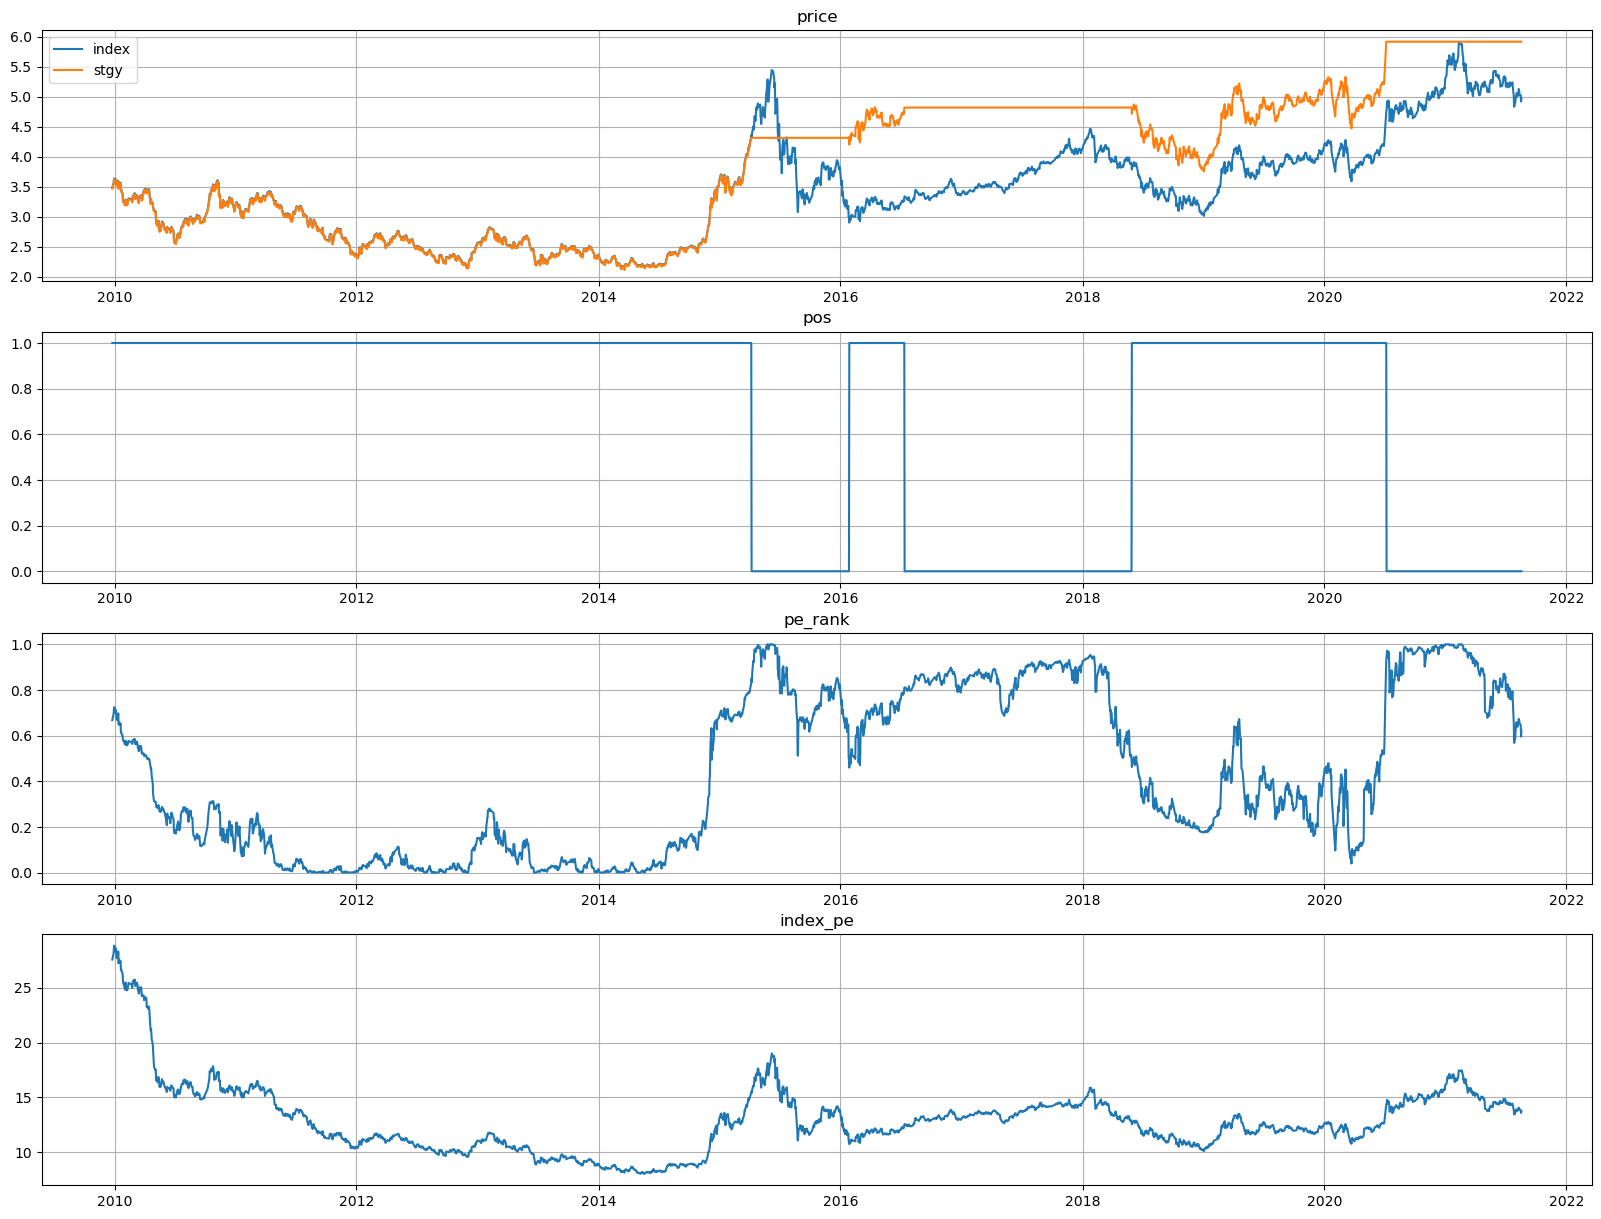

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def get_drawdown(p):
    hmax = p.cummax()
    return p / hmax - 1


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        return res
    ret = adjnav.pct_change()
    # annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242 / len(adjnav)) - 1  # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd
    return [annret, annvol, sr, mdd, calmar]


def datestr2dtdate(datestr):
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


# 定义工具函数
pctrank = lambda x: x.rank(pct=True).iloc[-1]

# 从csv文件获取指数价格数据
index_data = pd.read_csv('指数估值历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

# 设置回测参数
index_id = 'hs300'  # 选择指数
pe_rank_window = 242 * 5  # 计算PE分位数滑动窗口长度（按交易日数目）

# 回测过程
df = index_data.loc[:, [index_id]]
df['index_pe'] = index_data[index_id + '_pe']
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1 + df['index_ret']).cumprod().fillna(1)
df['pe_rank'] = df['index_pe'].rolling(window=pe_rank_window).apply(pctrank)
df['pos'] = np.nan
for t in range(pe_rank_window, len(df.index)):
    # 策略：高于0.8则空仓，回到0.5则重新满仓，否则保持昨仓
    prev_pe_rank = df.loc[df.index[t - 1], 'pe_rank']
    prev_pos = df.loc[df.index[t - 1], 'pos']
    prev_pos = 1 if np.isnan(prev_pos) else prev_pos
    df.loc[df.index[t], 'pos'] = 0 if prev_pe_rank > 0.8 else 1 if prev_pe_rank < 0.5 else prev_pos

# 计算回测业绩
backtest_start_date = index_data.index[pe_rank_window]
df['stgy_ret'] = df['pos'] * df['index_ret']
df['stgy'] = (1 + df['stgy_ret']).cumprod() * df.loc[backtest_start_date, 'index']

# 绘制回测结果走势图
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(4, 1, 1)
df.loc[backtest_start_date:, ['index', 'stgy']].plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(4, 1, 2)
df.loc[backtest_start_date:, 'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(4, 1, 3)
df.loc[backtest_start_date:, 'pe_rank'].plot(ax=ax3, grid=True, title='pe_rank')
ax4 = fig.add_subplot(4, 1, 4)
df.loc[backtest_start_date:, 'index_pe'].plot(ax=ax4, grid=True, title='index_pe')

# 计算回测业绩指标表
res = cal_period_perf_indicator(df.loc[backtest_start_date:, ['index', 'stgy']])
print(res)